# 16th International Modelica & FMI Conference Workshop
## FMUGym: From Uncertainty-Aware Simulation to Learning-Based Control with FMI and Python

### 0 Check all Imports

In [1]:
import os, sys
import time

import numpy as np
from scipy.optimize import differential_evolution, minimize
from scipy.interpolate import griddata

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from fmpy import read_model_description, extract

from fmugym import FMUGym, FMUGymConfig, VarSpace, State2Out, TargetValue

import gymnasium as gym
from stable_baselines3 import PPO

### 1 Implementation of abstract environment class

In [2]:
class FMUEnv(FMUGym):
    def __init__(self, config):
        self.init_states = {}
        super().__init__(config)
    
    # Use negative MSE of control error as reward
    def compute_reward(self, obs, info):
        reward = -obs[2]**2
        return reward
    
    ### Workshop specific utility functions ###
    def get_random_vars(self):
        params = {key: self.init_states[value[0]] for key, value in self.random_vars_refs.items()}
        return params
    
    def set_PID_params(self, k, Ti):
        self.random_vars_refs["speedController.k"][1].low = np.array([k])
        self.random_vars_refs["speedController.k"][1].high = np.array([k])
        self.random_vars_refs["speedController.Ti"][1].low = np.array([Ti])
        self.random_vars_refs["speedController.Ti"][1].high = np.array([Ti])
    
    def set_disturbance_torque(self, tau_min, tau_max):
        self.random_vars_refs["torqueStep.stepTorque"][1].low = np.array([tau_min])
        self.random_vars_refs["torqueStep.stepTorque"][1].high = np.array([tau_max])
    
    def set_spring_damper_parameters(self, d_bounds, k_bounds):
        self.random_vars_refs["damper.d"][1].low = np.array([d_bounds[0]])
        self.random_vars_refs["damper.d"][1].high = np.array([d_bounds[0]])
        self.random_vars_refs["spring.k"][1].low = np.array([k_bounds[0]])
        self.random_vars_refs["spring.k"][1].high = np.array([k_bounds[1]])

### 2 Parametrization and instantiation of simulation environment

In [3]:
inputs = VarSpace("inputs")
inputs.add_var_box("in_torque", -10.0, 10.0)

outputs = VarSpace("outputs")
outputs.add_var_box("out_control_err", -1e6, 1e6)
outputs.add_var_box("out_load_speed", -1e6, 1e6)
outputs.add_var_box("out_motor_speed", -1e6, 1e6)

random_vars = VarSpace("random_vars")
# uncertrain dynamic parameters for domain randomization
random_vars.add_var_box("damper.d", 10.0, 1000.0)
random_vars.add_var_box("spring.k", 1.0, 100.0)
# default control gains
random_vars.add_var_box("speedController.k", 80.0, 80.0)
random_vars.add_var_box("speedController.Ti", 1.0, 1.0) # s

# no external torque step value 
random_vars.add_var_box("torqueStep.stepTorque", 5.0, 5.0)

config = FMUGymConfig(fmu_path=os.path.abspath('DC_motor_workshop/DC_motor_dymola.fmu'),
                      start_time=0.0,
                      stop_time=2.0,
                      sim_step_size=0.005,
                      action_step_size=0.005,
                      inputs=inputs,
                      input_noise=None,
                      outputs=outputs,
                      output_noise=None,
                      random_vars=random_vars,
                     )                        

model_description = read_model_description(config.fmu_path)
print(model_description)

ModelDescription(fmiVersion='2.0', modelName='Credibility.Examples.SimpleControlledDriveNonlinear.DC_Motor_Monte_Carlo', coSimulation=CoSimulation(modelIdentifier='Credibility_Examples_SimpleControlledDriveNonlinear_DC_0Motor_0Monte_0Carlo'), modelExchange=None, scheduledExecution=None)


#### Instantiation

In [4]:
DCMotorEnv = FMUEnv(config)

### 4 Monte Carlo evaluation of uncertain dynamic parameters with classical controller 

#### Build dictionaries of indices for system parameters and outputs

In [5]:
idx_params = {}
idx_outs = {}

for i in range(len(DCMotorEnv.get_random_vars())):
    param_i = list(DCMotorEnv.get_random_vars().keys())[i]
    idx_params[param_i] = i
    print("Parameter to randomize: ", param_i, "at index", i)
    
for i in range(len(DCMotorEnv.output_dict)):
    out_i = list(DCMotorEnv.output_dict.keys())[i]
    idx_outs[out_i] = i
    print("Output: ", out_i, "at index", i)

Parameter to randomize:  spring.k at index 0
Parameter to randomize:  damper.d at index 1
Parameter to randomize:  speedController.k at index 2
Parameter to randomize:  speedController.Ti at index 3
Parameter to randomize:  torqueStep.stepTorque at index 4
Output:  out_motor_speed at index 0
Output:  out_load_speed at index 1
Output:  out_control_err at index 2


#### Monte Carlo simulation for N=500 episodes

In [6]:
num_episodes = 500
num_steps_per_episode = int((config.stop_time - config.start_time) / config.sim_step_size)
random_vars_collection = []
obs_collection = []

for iter in range(num_episodes):
    # resetting the environment and setting random initial and target values
    observation, info = DCMotorEnv.reset()
    obs_episode = [observation]

    # capturing trajectories here
    for k in range(num_steps_per_episode):
        action = 0
        observation, reward, terminated, truncated, info = DCMotorEnv.step(action)
        obs_episode.append(observation)
    random_vars_collection.append(list(DCMotorEnv.get_random_vars().values()))
    obs_collection.append(obs_episode)
    
random_vars_array = np.array(random_vars_collection)
obs_array = np.array(obs_collection)
squared_means = (obs_array**2).mean(axis=1)
mean_squared_errors = squared_means[:, idx_outs["out_control_err"]]

#### Plotting system parameter distribution, MSE and relation

Distribution of system paramters


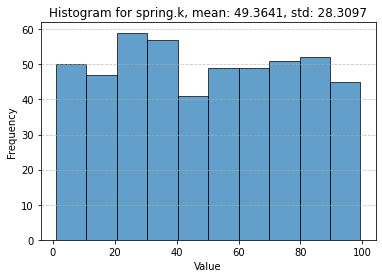

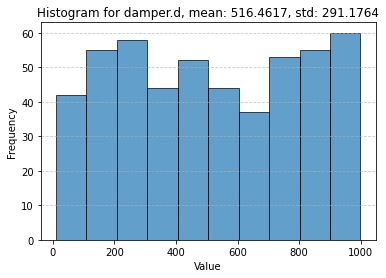

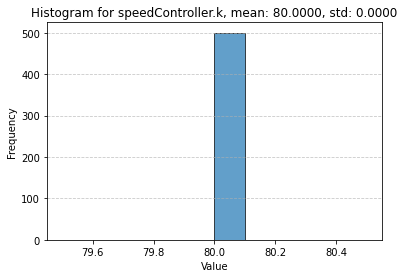

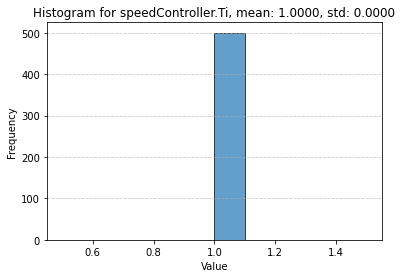

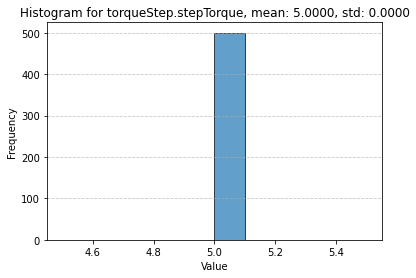

In [7]:
print("Distribution of system paramters")
for k in range(len(DCMotorEnv.get_random_vars())):
    plt.figure(figsize=(6, 4))
    plt.hist(random_vars_array[:, k], bins=10, edgecolor='black', alpha=0.7)
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {list(DCMotorEnv.get_random_vars().keys())[k]}, mean: {np.mean(random_vars_array[:, k]):.4f}, std: {np.std(random_vars_array[:, k]):.4f}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Distribution of MSE


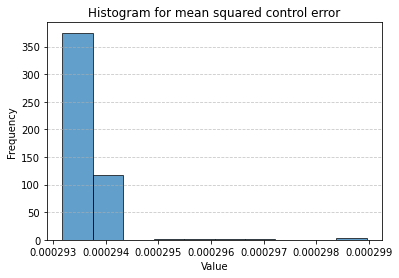

In [8]:
print("Distribution of MSE")
plt.figure(figsize=(6, 4))
plt.hist(mean_squared_errors, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"Histogram for mean squared control error")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

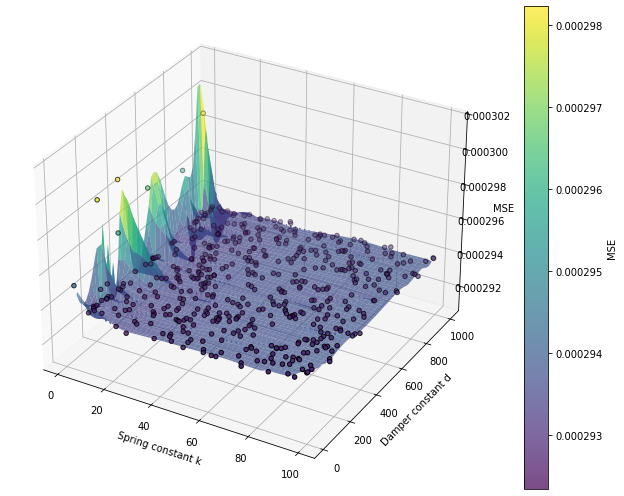

In [9]:
# Axes for 3D Plot
x = random_vars_array[:, idx_params["spring.k"]]
y = random_vars_array[:, idx_params["damper.d"]]
z = mean_squared_errors

# Create grid for surface
grid_x, grid_y = np.mgrid[
    x.min():x.max():100j,  # 100 points in each direction
    y.min():y.max():100j
]

# Interpolate MSE values onto the grid
grid_z = griddata(
    points=(x, y),
    values=z,
    xi=(grid_x, grid_y),
    method='cubic'  # can be 'linear', 'cubic', 'nearest'
)

# Create figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(
    grid_x, grid_y, grid_z,
    cmap='viridis',
    alpha=0.7,
    edgecolor='none'
)

# Also scatter plot for original points
ax.scatter(x, y, z, c=z, cmap='viridis', s=20, edgecolor='k')

# Colorbar
fig.colorbar(surf, ax=ax, label='MSE')

# Labels
ax.set_xlabel('Spring constant k')
ax.set_ylabel('Damper constant d')
ax.set_zlabel('MSE')

plt.tight_layout()
plt.show()


#### Ensemble plots of output timeseries

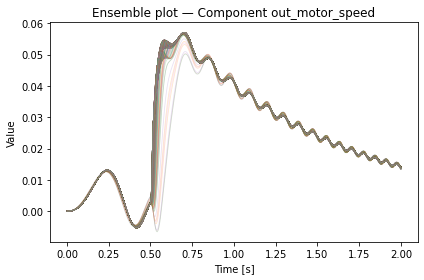

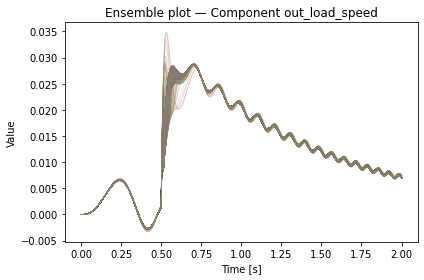

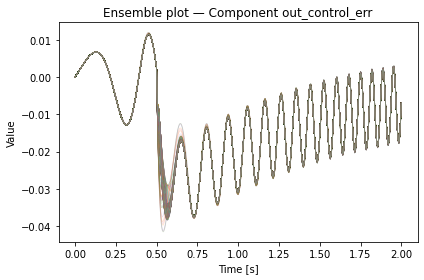

In [10]:
import numpy as np
import matplotlib.pyplot as plt

times = np.arange(config.start_time, config.stop_time+config.sim_step_size, step=config.sim_step_size)

for comp in range(obs_array.shape[2]):
    data = obs_array[:, :, comp]          
    plt.figure()
    # Plot all episodes as faint lines (ensemble)
    plt.plot(times[:], data.T, alpha=0.2, linewidth=0.8)

    plt.title(f"Ensemble plot — Component {list(idx_outs.keys())[comp]}")
    plt.xlabel("Time [s]")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

### 5 Manual PID Tuning for nominal system parameters

In [11]:
DCMotorEnv.set_spring_damper_parameters([100.0, 100.0], [1.0, 1.0])
DCMotorEnv.reset()
print("Nominal system parameters:")
print(DCMotorEnv.get_random_vars())

Nominal system parameters:
{'spring.k': 1.0, 'damper.d': 100.0, 'speedController.k': 80.0, 'speedController.Ti': 1.0, 'torqueStep.stepTorque': 5.0}


In [12]:
def obs_MSE_per_episode(Kp, Ti):
    DCMotorEnv.set_PID_params(Kp, Ti)
    
    num_steps_per_episode = int((config.stop_time - config.start_time) / config.sim_step_size)
    observation, info = DCMotorEnv.reset()
    obs_episode = [observation]
    
    # capturing trajectories here
    for k in range(num_steps_per_episode):
        action = 0
        observation, reward, terminated, truncated, info = DCMotorEnv.step(action)
        obs_episode.append(observation)

    obs_episode = np.array(obs_episode)
    mean_squared_error = (obs_episode**2).mean(axis=0)[idx_outs["out_control_err"]]
    
    return obs_episode, mean_squared_error

MSE:  0.000299129


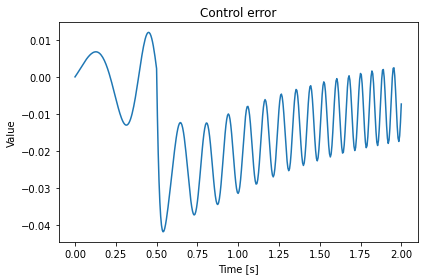

In [13]:
### PID parameters
Kp = 80
Ti = 1.0 # s
obs, mses = obs_MSE_per_episode(Kp, Ti)

print("MSE: ", mses)

plt.figure()
plt.plot(times, obs[:, idx_outs["out_control_err"]])
plt.title("Control error")
plt.xlabel("Time [s]")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

### 6 Optimize PID gains for uncertainty in system parameters and amplitude of torque disturbance

In [14]:
DCMotorEnv.set_disturbance_torque(2.5, 7.5) # disturbance torque step now varies
DCMotorEnv.set_spring_damper_parameters([10.0, 1000.0], [1.0, 100.0]) # original parameter range

In [15]:
# only take MSE, no other observations
def MSE_per_episode(Kp, Ti):
    _, MSE = obs_MSE_per_episode(Kp, Ti)
    return MSE
    
# utilize classic optimization function from scipy
def optimize_PID_gains(mse_fn, bounds, x0=None, seed=41, maxiter=200, polish=True, **mse_kwargs):
    # Global search
    de_res = differential_evolution(
        lambda p: float(mse_fn(*p, **mse_kwargs)), 
        bounds=bounds,
        seed=seed,
        maxiter=maxiter,
        updating='deferred',
        workers=1,
        polish=False
    )

    best_x = de_res.x if x0 is None else np.asarray(x0, dtype=float)

    # Optional local polish
    lbfgs_res = None
    if polish:
        lbfgs_res = minimize(
            lambda p: float(mse_fn(*p, **mse_kwargs)),
            x0=best_x,
            method='L-BFGS-B',
            bounds=bounds
        )
        final_x, final_mse = lbfgs_res.x, float(lbfgs_res.fun)
        success, message = bool(lbfgs_res.success), str(lbfgs_res.message)
    else:
        final_x, final_mse = de_res.x, float(de_res.fun)
        success, message = bool(de_res.success), str(de_res.message)

    return {
        'x': np.asarray(final_x, dtype=float),
        'mse': float(final_mse),
        'success': success,
        'message': message,
        'global_result': de_res,
        'local_result': lbfgs_res
    }

In [17]:
timer_start_time = time.time()
bounds = [(1.0, 150), (0.01, 10.0)]
# if it takes >3 min, reduce maxiter parameter
res = optimize_PID_gains(MSE_per_episode, bounds, seed=0, maxiter=100)
print(res)
print("optimization duration: ", time.time() - timer_start_time)

{'x': array([1.45479277e+02, 1.06776076e-02]), 'mse': 5.734119258704595e-05, 'success': False, 'message': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'global_result':      fun: 5.6008128012763336e-05
 message: 'Optimization terminated successfully.'
    nfev: 1050
     nit: 34
 success: True
       x: array([1.45479277e+02, 1.06776076e-02]), 'local_result':       fun: 5.734119258704595e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([138.3944248 , -45.07128324])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 63
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([1.45479277e+02, 1.06776076e-02])}
optimization duration:  37.06116199493408


#### Compare with previous parametrization

In [18]:
num_eps = 100

mse_sum = 0.0
for i in range(num_eps):
    mse_sum += MSE_per_episode(Kp, Ti)
print(f"Mean squared error for Kp = {Kp} and Ti = {Ti}: {mse_sum/(num_eps)}")

mse_sum = 0.0
for i in range(num_eps):
    mse_sum += MSE_per_episode(*res["x"])
print(f"Mean squared error for Kp = {res['x'][0]} and Ti = {res['x'][1]}: {mse_sum/(num_eps)}")

Mean squared error for Kp = 80 and Ti = 1.0: 0.0003056112423655577
Mean squared error for Kp = 145.47927668304018 and Ti = 0.010677607624448804: 0.00014567448135494488


### 7 Training a residual RL policy to improve disturbance rejection

In [16]:
Kp = 100
Ti = 0.1
DCMotorEnv.set_PID_params(Kp, Ti)
DCMotorEnv.reset()

(array([0., 0., 0.], dtype=float32), {'sample_msg': 'sample message'})

#### Instantiate an RL agent to be trained with the PPO algorithm

In [26]:
model = PPO(
    "MlpPolicy",
    DCMotorEnv,
    verbose=1,
    #tensorboard_log="/tmp/tensor_board"
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [22]:
# structure of NN
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

#### Train the agent for < 5 min

In [23]:
timer_start_time = time.time()
model.learn(total_timesteps=250_000)
print("learn duration: ", time.time() - timer_start_time)

Logging to /tmp/tensor_board/PPO_1

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 402      |
|    ep_rew_mean     | -0.0351  |
| time/              |          |
|    fps             | 2048     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0363      |
| time/                   |              |
|    fps                  | 1622         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0044664764 |
|    clip_fraction        | 0.00356      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.661       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000101     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000698    |
|    std                  | 0.995        |
|    value_loss           | 2.42e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0375     |
| time/                   |             |
|    fps                  | 1522        |
|    iterations           | 3           |
|    time_elapsed         | 4           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.004738352 |
|    clip_fraction        | 0.0276      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.143       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0126     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0021     |
|    std                  | 0.989       |
|    value_loss           | 2.55e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0383      |
| time/                   |              |
|    fps                  | 1483         |
|    iterations           | 4            |
|    time_elapsed         | 5            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0041593313 |
|    clip_fraction        | 0.0175       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.162        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0119       |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.00129     |
|    std                  | 0.983        |
|    value_loss           | 3.88e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0387      |
| time/                   |              |
|    fps                  | 1456         |
|    iterations           | 5            |
|    time_elapsed         | 7            |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0008388908 |
|    clip_fraction        | 0.00464      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.163        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000346    |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000675    |
|    std                  | 0.963        |
|    value_loss           | 3.71e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0385     |
| time/                   |             |
|    fps                  | 1441        |
|    iterations           | 6           |
|    time_elapsed         | 8           |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.004981508 |
|    clip_fraction        | 0.0302      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.193       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00643     |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.00156    |
|    std                  | 0.953       |
|    value_loss           | 4.2e-06     |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0381      |
| time/                   |              |
|    fps                  | 1429         |
|    iterations           | 7            |
|    time_elapsed         | 10           |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 0.0017789887 |
|    clip_fraction        | 0.00757      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.17         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00531     |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00104     |
|    std                  | 0.925        |
|    value_loss           | 2.83e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.038      |
| time/                   |             |
|    fps                  | 1421        |
|    iterations           | 8           |
|    time_elapsed         | 11          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.006095498 |
|    clip_fraction        | 0.0699      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.184       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0365     |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00381    |
|    std                  | 0.918       |
|    value_loss           | 3.29e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0381      |
| time/                   |              |
|    fps                  | 1414         |
|    iterations           | 9            |
|    time_elapsed         | 13           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0069754873 |
|    clip_fraction        | 0.0557       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.33        |
|    explained_variance   | 0.187        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00781      |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00345     |
|    std                  | 0.913        |
|    value_loss           | 3.44e-06     |
------------------------------------------

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 402       |
|    ep_rew_mean          | -0.0376   |
| time/                   |           |
|    fps                  | 1409      |
|    iterations           | 10        |
|    time_elapsed         | 14        |
|    total_timesteps      | 20480     |
| train/                  |           |
|    approx_kl            | 0.0035203 |
|    clip_fraction        | 0.0331    |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.33     |
|    explained_variance   | 0.18      |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0172   |
|    n_updates            | 90        |
|    policy_gradient_loss | -0.00185  |
|    std                  | 0.915     |
|    value_loss           | 3.79e-06  |
---------------------------------------

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 402       |
|    ep_rew_mean          | -0.0374   |
| time/                   |           |
|    fps                  | 1400      |
|    iterations           | 11        |
|    time_elapsed         | 16        |
|    total_timesteps      | 22528     |
| train/                  |           |
|    approx_kl            | 0.0066275 |
|    clip_fraction        | 0.029     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.33     |
|    explained_variance   | 0.15      |
|    learning_rate        | 0.0003    |
|    loss                 | 0.00549   |
|    n_updates            | 100       |
|    policy_gradient_loss | -0.00135  |
|    std                  | 0.909     |
|    value_loss           | 2.96e-06  |
---------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0374      |
| time/                   |              |
|    fps                  | 1394         |
|    iterations           | 12           |
|    time_elapsed         | 17           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0020539837 |
|    clip_fraction        | 0.0161       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.158        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00257      |
|    n_updates            | 110          |
|    policy_gradient_loss | 9.98e-06     |
|    std                  | 0.907        |
|    value_loss           | 3.37e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0375      |
| time/                   |              |
|    fps                  | 1391         |
|    iterations           | 13           |
|    time_elapsed         | 19           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0008682483 |
|    clip_fraction        | 0.00317      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.31        |
|    explained_variance   | 0.153        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000725    |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.000544    |
|    std                  | 0.884        |
|    value_loss           | 4.21e-06     |
------------------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 402           |
|    ep_rew_mean          | -0.0375       |
| time/                   |               |
|    fps                  | 1389          |
|    iterations           | 14            |
|    time_elapsed         | 20            |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 0.00034611937 |
|    clip_fraction        | 0.0524        |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.29         |
|    explained_variance   | 0.217         |
|    learning_rate        | 0.0003        |
|    loss                 | -0.000504     |
|    n_updates            | 130           |
|    policy_gradient_loss | -0.0017       |
|    std                  | 0.873         |
|    value_loss           | 4.12e-06      |
-------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0375      |
| time/                   |              |
|    fps                  | 1386         |
|    iterations           | 15           |
|    time_elapsed         | 22           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0002197345 |
|    clip_fraction        | 0.00176      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.231        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00384     |
|    n_updates            | 140          |
|    policy_gradient_loss | 0.000314     |
|    std                  | 0.864        |
|    value_loss           | 4.44e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0373      |
| time/                   |              |
|    fps                  | 1385         |
|    iterations           | 16           |
|    time_elapsed         | 23           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0015851876 |
|    clip_fraction        | 0.0193       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.215        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000334     |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.000697    |
|    std                  | 0.858        |
|    value_loss           | 4.61e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0373      |
| time/                   |              |
|    fps                  | 1380         |
|    iterations           | 17           |
|    time_elapsed         | 25           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0026123966 |
|    clip_fraction        | 0.00889      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.171        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.000741     |
|    n_updates            | 160          |
|    policy_gradient_loss | -2.81e-06    |
|    std                  | 0.865        |
|    value_loss           | 3.37e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0373     |
| time/                   |             |
|    fps                  | 1375        |
|    iterations           | 18          |
|    time_elapsed         | 26          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.004014989 |
|    clip_fraction        | 0.0186      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.214       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000422   |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00088    |
|    std                  | 0.877       |
|    value_loss           | 4.22e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0373      |
| time/                   |              |
|    fps                  | 1371         |
|    iterations           | 19           |
|    time_elapsed         | 28           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0008940806 |
|    clip_fraction        | 0.00435      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.28        |
|    explained_variance   | 0.218        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000975    |
|    n_updates            | 180          |
|    policy_gradient_loss | 1.98e-06     |
|    std                  | 0.863        |
|    value_loss           | 4.25e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0371      |
| time/                   |              |
|    fps                  | 1367         |
|    iterations           | 20           |
|    time_elapsed         | 29           |
|    total_timesteps      | 40960        |
| train/                  |              |
|    approx_kl            | 0.0050982106 |
|    clip_fraction        | 0.0254       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.194        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.022        |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.859        |
|    value_loss           | 4.13e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0372     |
| time/                   |             |
|    fps                  | 1363        |
|    iterations           | 21          |
|    time_elapsed         | 31          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.005077002 |
|    clip_fraction        | 0.0498      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.0837      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0106      |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00313    |
|    std                  | 0.852       |
|    value_loss           | 2.21e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.037       |
| time/                   |              |
|    fps                  | 1358         |
|    iterations           | 22           |
|    time_elapsed         | 33           |
|    total_timesteps      | 45056        |
| train/                  |              |
|    approx_kl            | 0.0014961424 |
|    clip_fraction        | 0.0118       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.25        |
|    explained_variance   | 0.104        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00275      |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.000835    |
|    std                  | 0.839        |
|    value_loss           | 3.64e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0365      |
| time/                   |              |
|    fps                  | 1357         |
|    iterations           | 23           |
|    time_elapsed         | 34           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0015789683 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.116        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00478      |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00138     |
|    std                  | 0.828        |
|    value_loss           | 3.73e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0362      |
| time/                   |              |
|    fps                  | 1354         |
|    iterations           | 24           |
|    time_elapsed         | 36           |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0037134783 |
|    clip_fraction        | 0.0261       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.102        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00401     |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.000539    |
|    std                  | 0.82         |
|    value_loss           | 3.03e-06     |
------------------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 402           |
|    ep_rew_mean          | -0.0358       |
| time/                   |               |
|    fps                  | 1353          |
|    iterations           | 25            |
|    time_elapsed         | 37            |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | 0.00093192555 |
|    clip_fraction        | 0.00566       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.22         |
|    explained_variance   | 0.145         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.00761       |
|    n_updates            | 240           |
|    policy_gradient_loss | -0.000376     |
|    std                  | 0.816         |
|    value_loss           | 3.03e-06      |
-------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0357     |
| time/                   |             |
|    fps                  | 1349        |
|    iterations           | 26          |
|    time_elapsed         | 39          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.005382744 |
|    clip_fraction        | 0.0516      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.143       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0024      |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00358    |
|    std                  | 0.802       |
|    value_loss           | 2.06e-06    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0354     |
| time/                   |             |
|    fps                  | 1348        |
|    iterations           | 27          |
|    time_elapsed         | 41          |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.002312442 |
|    clip_fraction        | 0.0526      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.2        |
|    explained_variance   | 0.165       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00375    |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00316    |
|    std                  | 0.803       |
|    value_loss           | 3.4e-06     |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.035       |
| time/                   |              |
|    fps                  | 1348         |
|    iterations           | 28           |
|    time_elapsed         | 42           |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0008405609 |
|    clip_fraction        | 0.026        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.0941       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00184      |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.000827    |
|    std                  | 0.821        |
|    value_loss           | 1.89e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0346      |
| time/                   |              |
|    fps                  | 1347         |
|    iterations           | 29           |
|    time_elapsed         | 44           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0018327303 |
|    clip_fraction        | 0.0162       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.0375       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0257       |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.000221    |
|    std                  | 0.807        |
|    value_loss           | 1.36e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0346     |
| time/                   |             |
|    fps                  | 1347        |
|    iterations           | 30          |
|    time_elapsed         | 45          |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.006392408 |
|    clip_fraction        | 0.0604      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.109       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0037     |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.00306    |
|    std                  | 0.794       |
|    value_loss           | 1.6e-06     |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0344      |
| time/                   |              |
|    fps                  | 1347         |
|    iterations           | 31           |
|    time_elapsed         | 47           |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0024003736 |
|    clip_fraction        | 0.028        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.131        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00473      |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00136     |
|    std                  | 0.794        |
|    value_loss           | 1.79e-06     |
------------------------------------------

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 402           |
|    ep_rew_mean          | -0.0339       |
| time/                   |               |
|    fps                  | 1346          |
|    iterations           | 32            |
|    time_elapsed         | 48            |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | 0.00076048006 |
|    clip_fraction        | 0.0125        |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.18         |
|    explained_variance   | 0.138         |
|    learning_rate        | 0.0003        |
|    loss                 | 0.0133        |
|    n_updates            | 310           |
|    policy_gradient_loss | -0.000323     |
|    std                  | 0.79          |
|    value_loss           | 1.96e-06      |
-------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0333     |
| time/                   |             |
|    fps                  | 1346        |
|    iterations           | 33          |
|    time_elapsed         | 50          |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.003109991 |
|    clip_fraction        | 0.0416      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | 0.131       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0065      |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.00181    |
|    std                  | 0.792       |
|    value_loss           | 2.13e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0329      |
| time/                   |              |
|    fps                  | 1345         |
|    iterations           | 34           |
|    time_elapsed         | 51           |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 0.0008879206 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.121        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00349      |
|    n_updates            | 330          |
|    policy_gradient_loss | 0.000462     |
|    std                  | 0.797        |
|    value_loss           | 1.64e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0325     |
| time/                   |             |
|    fps                  | 1345        |
|    iterations           | 35          |
|    time_elapsed         | 53          |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.004430882 |
|    clip_fraction        | 0.0219      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.19       |
|    explained_variance   | 0.156       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00428     |
|    n_updates            | 340         |
|    policy_gradient_loss | 0.00106     |
|    std                  | 0.787       |
|    value_loss           | 1.66e-06    |
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0321    |
| time/                   |            |
|    fps                  | 1342       |
|    iterations           | 36         |
|    time_elapsed         | 54         |
|    total_timesteps      | 73728      |
| train/                  |            |
|    approx_kl            | 0.00997388 |
|    clip_fraction        | 0.0519     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.18      |
|    explained_variance   | 0.154      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0131    |
|    n_updates            | 350        |
|    policy_gradient_loss | -0.00312   |
|    std                  | 0.78       |
|    value_loss           | 1.67e-06   |
----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0315      |
| time/                   |              |
|    fps                  | 1341         |
|    iterations           | 37           |
|    time_elapsed         | 56           |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0059816353 |
|    clip_fraction        | 0.0503       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.17        |
|    explained_variance   | 0.0979       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0171       |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.00158     |
|    std                  | 0.772        |
|    value_loss           | 1.93e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0309     |
| time/                   |             |
|    fps                  | 1341        |
|    iterations           | 38          |
|    time_elapsed         | 58          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.004231765 |
|    clip_fraction        | 0.0273      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.15       |
|    explained_variance   | 0.111       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0131     |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.000583   |
|    std                  | 0.766       |
|    value_loss           | 1.03e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0304      |
| time/                   |              |
|    fps                  | 1339         |
|    iterations           | 39           |
|    time_elapsed         | 59           |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0042483127 |
|    clip_fraction        | 0.0388       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.16        |
|    explained_variance   | 0.134        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00939     |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00163     |
|    std                  | 0.775        |
|    value_loss           | 1.12e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0301     |
| time/                   |             |
|    fps                  | 1327        |
|    iterations           | 40          |
|    time_elapsed         | 61          |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.003305662 |
|    clip_fraction        | 0.0199      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.16       |
|    explained_variance   | 0.0961      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00723    |
|    n_updates            | 390         |
|    policy_gradient_loss | -2.16e-05   |
|    std                  | 0.768       |
|    value_loss           | 2.04e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0296      |
| time/                   |              |
|    fps                  | 1324         |
|    iterations           | 41           |
|    time_elapsed         | 63           |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0022228444 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.14        |
|    explained_variance   | 0.14         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00423     |
|    n_updates            | 400          |
|    policy_gradient_loss | -1.61e-05    |
|    std                  | 0.746        |
|    value_loss           | 1.59e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0292      |
| time/                   |              |
|    fps                  | 1321         |
|    iterations           | 42           |
|    time_elapsed         | 65           |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0035900297 |
|    clip_fraction        | 0.0289       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.13        |
|    explained_variance   | 0.138        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00458     |
|    n_updates            | 410          |
|    policy_gradient_loss | 0.00111      |
|    std                  | 0.747        |
|    value_loss           | 1.54e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0285      |
| time/                   |              |
|    fps                  | 1318         |
|    iterations           | 43           |
|    time_elapsed         | 66           |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0038331533 |
|    clip_fraction        | 0.06         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.13        |
|    explained_variance   | 0.118        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0125      |
|    n_updates            | 420          |
|    policy_gradient_loss | -0.00322     |
|    std                  | 0.746        |
|    value_loss           | 9.34e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.028      |
| time/                   |             |
|    fps                  | 1317        |
|    iterations           | 44          |
|    time_elapsed         | 68          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.003664203 |
|    clip_fraction        | 0.0374      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.136       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000423    |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.000573   |
|    std                  | 0.737       |
|    value_loss           | 1.15e-06    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0277     |
| time/                   |             |
|    fps                  | 1315        |
|    iterations           | 45          |
|    time_elapsed         | 70          |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.004265326 |
|    clip_fraction        | 0.0486      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.11       |
|    explained_variance   | 0.0719      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00591    |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.000862   |
|    std                  | 0.74        |
|    value_loss           | 1.91e-06    |
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0271    |
| time/                   |            |
|    fps                  | 1314       |
|    iterations           | 46         |
|    time_elapsed         | 71         |
|    total_timesteps      | 94208      |
| train/                  |            |
|    approx_kl            | 0.00685227 |
|    clip_fraction        | 0.0431     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.11      |
|    explained_variance   | 0.102      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.00768    |
|    n_updates            | 450        |
|    policy_gradient_loss | 0.000177   |
|    std                  | 0.73       |
|    value_loss           | 1.39e-06   |
----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0268      |
| time/                   |              |
|    fps                  | 1314         |
|    iterations           | 47           |
|    time_elapsed         | 73           |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0040580854 |
|    clip_fraction        | 0.044        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.124        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00537      |
|    n_updates            | 460          |
|    policy_gradient_loss | -0.000475    |
|    std                  | 0.731        |
|    value_loss           | 1.45e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0265      |
| time/                   |              |
|    fps                  | 1312         |
|    iterations           | 48           |
|    time_elapsed         | 74           |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0034531076 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.116        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00567     |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.000716    |
|    std                  | 0.723        |
|    value_loss           | 3.56e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.026       |
| time/                   |              |
|    fps                  | 1312         |
|    iterations           | 49           |
|    time_elapsed         | 76           |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0035274778 |
|    clip_fraction        | 0.035        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.105        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00673     |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00121     |
|    std                  | 0.715        |
|    value_loss           | 9.06e-07     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0253      |
| time/                   |              |
|    fps                  | 1308         |
|    iterations           | 50           |
|    time_elapsed         | 78           |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0050111883 |
|    clip_fraction        | 0.031        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.08        |
|    explained_variance   | 0.0946       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0125       |
|    n_updates            | 490          |
|    policy_gradient_loss | 0.000657     |
|    std                  | 0.71         |
|    value_loss           | 8.51e-07     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0249      |
| time/                   |              |
|    fps                  | 1308         |
|    iterations           | 51           |
|    time_elapsed         | 79           |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0028214878 |
|    clip_fraction        | 0.022        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.06        |
|    explained_variance   | 0.127        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00305      |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.000328    |
|    std                  | 0.69         |
|    value_loss           | 9.5e-07      |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0243      |
| time/                   |              |
|    fps                  | 1308         |
|    iterations           | 52           |
|    time_elapsed         | 81           |
|    total_timesteps      | 106496       |
| train/                  |              |
|    approx_kl            | 0.0028694766 |
|    clip_fraction        | 0.0284       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | 0.0659       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0165      |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.00102     |
|    std                  | 0.687        |
|    value_loss           | 1.77e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0239     |
| time/                   |             |
|    fps                  | 1306        |
|    iterations           | 53          |
|    time_elapsed         | 83          |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.008817889 |
|    clip_fraction        | 0.0717      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.04       |
|    explained_variance   | 0.0583      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00653    |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00441    |
|    std                  | 0.676       |
|    value_loss           | 8.01e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0234     |
| time/                   |             |
|    fps                  | 1306        |
|    iterations           | 54          |
|    time_elapsed         | 84          |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.005791905 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | 0.12        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00782    |
|    n_updates            | 530         |
|    policy_gradient_loss | 0.000121    |
|    std                  | 0.67        |
|    value_loss           | 4.48e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0229      |
| time/                   |              |
|    fps                  | 1305         |
|    iterations           | 55           |
|    time_elapsed         | 86           |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0029740324 |
|    clip_fraction        | 0.0322       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.02        |
|    explained_variance   | 0.115        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00313     |
|    n_updates            | 540          |
|    policy_gradient_loss | 0.00148      |
|    std                  | 0.667        |
|    value_loss           | 4.79e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0226     |
| time/                   |             |
|    fps                  | 1298        |
|    iterations           | 56          |
|    time_elapsed         | 88          |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.007054441 |
|    clip_fraction        | 0.0669      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.103       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0147      |
|    n_updates            | 550         |
|    policy_gradient_loss | 0.00118     |
|    std                  | 0.663       |
|    value_loss           | 5.33e-07    |
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0223    |
| time/                   |            |
|    fps                  | 1296       |
|    iterations           | 57         |
|    time_elapsed         | 90         |
|    total_timesteps      | 116736     |
| train/                  |            |
|    approx_kl            | 0.00220954 |
|    clip_fraction        | 0.0453     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1         |
|    explained_variance   | 0.099      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00182   |
|    n_updates            | 560        |
|    policy_gradient_loss | 0.000959   |
|    std                  | 0.657      |
|    value_loss           | 5.75e-07   |
----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0218      |
| time/                   |              |
|    fps                  | 1293         |
|    iterations           | 58           |
|    time_elapsed         | 91           |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0043027094 |
|    clip_fraction        | 0.0641       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.988       |
|    explained_variance   | 0.137        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0195       |
|    n_updates            | 570          |
|    policy_gradient_loss | 0.000949     |
|    std                  | 0.645        |
|    value_loss           | 9.94e-07     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0214      |
| time/                   |              |
|    fps                  | 1290         |
|    iterations           | 59           |
|    time_elapsed         | 93           |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0058175847 |
|    clip_fraction        | 0.0615       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.97        |
|    explained_variance   | 0.0434       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00279     |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.0008      |
|    std                  | 0.633        |
|    value_loss           | 8.37e-07     |
------------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0209    |
| time/                   |            |
|    fps                  | 1285       |
|    iterations           | 60         |
|    time_elapsed         | 95         |
|    total_timesteps      | 122880     |
| train/                  |            |
|    approx_kl            | 0.00811106 |
|    clip_fraction        | 0.0957     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.956     |
|    explained_variance   | 0.109      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00588   |
|    n_updates            | 590        |
|    policy_gradient_loss | -0.00436   |
|    std                  | 0.627      |
|    value_loss           | 8.98e-07   |
----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0206      |
| time/                   |              |
|    fps                  | 1285         |
|    iterations           | 61           |
|    time_elapsed         | 97           |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 0.0073971217 |
|    clip_fraction        | 0.0544       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.95        |
|    explained_variance   | 0.0673       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00834     |
|    n_updates            | 600          |
|    policy_gradient_loss | 0.000695     |
|    std                  | 0.624        |
|    value_loss           | 2.35e-06     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0202      |
| time/                   |              |
|    fps                  | 1284         |
|    iterations           | 62           |
|    time_elapsed         | 98           |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0064330474 |
|    clip_fraction        | 0.0709       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.938       |
|    explained_variance   | 0.0615       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00229      |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.000437    |
|    std                  | 0.612        |
|    value_loss           | 5.78e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0199     |
| time/                   |             |
|    fps                  | 1282        |
|    iterations           | 63          |
|    time_elapsed         | 100         |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.003771103 |
|    clip_fraction        | 0.054       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.927      |
|    explained_variance   | 0.0739      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0192      |
|    n_updates            | 620         |
|    policy_gradient_loss | 0.00204     |
|    std                  | 0.61        |
|    value_loss           | 8.27e-07    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0196      |
| time/                   |              |
|    fps                  | 1279         |
|    iterations           | 64           |
|    time_elapsed         | 102          |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0042431657 |
|    clip_fraction        | 0.0417       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.928       |
|    explained_variance   | 0.0839       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0122      |
|    n_updates            | 630          |
|    policy_gradient_loss | 0.00122      |
|    std                  | 0.614        |
|    value_loss           | 2.65e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0193     |
| time/                   |             |
|    fps                  | 1278        |
|    iterations           | 65          |
|    time_elapsed         | 104         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.005539481 |
|    clip_fraction        | 0.0627      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.925      |
|    explained_variance   | 0.0611      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00718    |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00126    |
|    std                  | 0.607       |
|    value_loss           | 6.29e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0189     |
| time/                   |             |
|    fps                  | 1276        |
|    iterations           | 66          |
|    time_elapsed         | 105         |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.011391215 |
|    clip_fraction        | 0.0902      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.912      |
|    explained_variance   | 0.0792      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00476     |
|    n_updates            | 650         |
|    policy_gradient_loss | 7.04e-05    |
|    std                  | 0.6         |
|    value_loss           | 6.18e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0186     |
| time/                   |             |
|    fps                  | 1275        |
|    iterations           | 67          |
|    time_elapsed         | 107         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.008103917 |
|    clip_fraction        | 0.0736      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.897      |
|    explained_variance   | 0.0852      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00374     |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.00234    |
|    std                  | 0.587       |
|    value_loss           | 4.88e-07    |
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0183    |
| time/                   |            |
|    fps                  | 1275       |
|    iterations           | 68         |
|    time_elapsed         | 109        |
|    total_timesteps      | 139264     |
| train/                  |            |
|    approx_kl            | 0.00989682 |
|    clip_fraction        | 0.091      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.877     |
|    explained_variance   | 0.128      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0057     |
|    n_updates            | 670        |
|    policy_gradient_loss | 0.00297    |
|    std                  | 0.578      |
|    value_loss           | 1.04e-05   |
----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0181      |
| time/                   |              |
|    fps                  | 1276         |
|    iterations           | 69           |
|    time_elapsed         | 110          |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0040784357 |
|    clip_fraction        | 0.0412       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.868       |
|    explained_variance   | 0.0873       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0023       |
|    n_updates            | 680          |
|    policy_gradient_loss | 0.00135      |
|    std                  | 0.573        |
|    value_loss           | 4.07e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0178     |
| time/                   |             |
|    fps                  | 1277        |
|    iterations           | 70          |
|    time_elapsed         | 112         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.004085023 |
|    clip_fraction        | 0.0677      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.857      |
|    explained_variance   | 0.132       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000228   |
|    n_updates            | 690         |
|    policy_gradient_loss | 0.00165     |
|    std                  | 0.567       |
|    value_loss           | 4.22e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0176     |
| time/                   |             |
|    fps                  | 1278        |
|    iterations           | 71          |
|    time_elapsed         | 113         |
|    total_timesteps      | 145408      |
| train/                  |             |
|    approx_kl            | 0.005379646 |
|    clip_fraction        | 0.0647      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.847      |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0217     |
|    n_updates            | 700         |
|    policy_gradient_loss | 0.00125     |
|    std                  | 0.563       |
|    value_loss           | 4.29e-07    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0174      |
| time/                   |              |
|    fps                  | 1278         |
|    iterations           | 72           |
|    time_elapsed         | 115          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0039100684 |
|    clip_fraction        | 0.0757       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.838       |
|    explained_variance   | 0.0918       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00256      |
|    n_updates            | 710          |
|    policy_gradient_loss | 0.000148     |
|    std                  | 0.557        |
|    value_loss           | 4.69e-07     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0171      |
| time/                   |              |
|    fps                  | 1279         |
|    iterations           | 73           |
|    time_elapsed         | 116          |
|    total_timesteps      | 149504       |
| train/                  |              |
|    approx_kl            | 0.0043251226 |
|    clip_fraction        | 0.0839       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.82        |
|    explained_variance   | 0.128        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00419      |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00109     |
|    std                  | 0.543        |
|    value_loss           | 1.84e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0169     |
| time/                   |             |
|    fps                  | 1280        |
|    iterations           | 74          |
|    time_elapsed         | 118         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.012438191 |
|    clip_fraction        | 0.0616      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.807      |
|    explained_variance   | 0.0601      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00189     |
|    n_updates            | 730         |
|    policy_gradient_loss | 0.00162     |
|    std                  | 0.542       |
|    value_loss           | 6.13e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0166     |
| time/                   |             |
|    fps                  | 1280        |
|    iterations           | 75          |
|    time_elapsed         | 119         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.008162181 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.8        |
|    explained_variance   | 0.0592      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.011      |
|    n_updates            | 740         |
|    policy_gradient_loss | 0.00182     |
|    std                  | 0.536       |
|    value_loss           | 5.32e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0164     |
| time/                   |             |
|    fps                  | 1281        |
|    iterations           | 76          |
|    time_elapsed         | 121         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.005267862 |
|    clip_fraction        | 0.091       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.791      |
|    explained_variance   | 0.0907      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000855   |
|    n_updates            | 750         |
|    policy_gradient_loss | 0.0041      |
|    std                  | 0.533       |
|    value_loss           | 1.29e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0162      |
| time/                   |              |
|    fps                  | 1282         |
|    iterations           | 77           |
|    time_elapsed         | 122          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0046161367 |
|    clip_fraction        | 0.082        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.783       |
|    explained_variance   | 0.0623       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00196      |
|    n_updates            | 760          |
|    policy_gradient_loss | 0.0021       |
|    std                  | 0.526        |
|    value_loss           | 1.2e-06      |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.016       |
| time/                   |              |
|    fps                  | 1283         |
|    iterations           | 78           |
|    time_elapsed         | 124          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0067171054 |
|    clip_fraction        | 0.0741       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.772       |
|    explained_variance   | 0.0737       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00918     |
|    n_updates            | 770          |
|    policy_gradient_loss | 0.00156      |
|    std                  | 0.521        |
|    value_loss           | 1.08e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0158     |
| time/                   |             |
|    fps                  | 1283        |
|    iterations           | 79          |
|    time_elapsed         | 126         |
|    total_timesteps      | 161792      |
| train/                  |             |
|    approx_kl            | 0.010272291 |
|    clip_fraction        | 0.0769      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.759      |
|    explained_variance   | 0.0905      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00838     |
|    n_updates            | 780         |
|    policy_gradient_loss | 0.00294     |
|    std                  | 0.513       |
|    value_loss           | 6.68e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0156      |
| time/                   |              |
|    fps                  | 1284         |
|    iterations           | 80           |
|    time_elapsed         | 127          |
|    total_timesteps      | 163840       |
| train/                  |              |
|    approx_kl            | 0.0045240577 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.746       |
|    explained_variance   | 0.11         |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0101      |
|    n_updates            | 790          |
|    policy_gradient_loss | 0.00313      |
|    std                  | 0.508        |
|    value_loss           | 4.38e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0154     |
| time/                   |             |
|    fps                  | 1285        |
|    iterations           | 81          |
|    time_elapsed         | 129         |
|    total_timesteps      | 165888      |
| train/                  |             |
|    approx_kl            | 0.016841209 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.732      |
|    explained_variance   | 0.0842      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00921    |
|    n_updates            | 800         |
|    policy_gradient_loss | 0.00388     |
|    std                  | 0.501       |
|    value_loss           | 4.83e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0153     |
| time/                   |             |
|    fps                  | 1284        |
|    iterations           | 82          |
|    time_elapsed         | 130         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.004205116 |
|    clip_fraction        | 0.0798      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.726      |
|    explained_variance   | 0.161       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0129      |
|    n_updates            | 810         |
|    policy_gradient_loss | 0.00177     |
|    std                  | 0.499       |
|    value_loss           | 5.32e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0152     |
| time/                   |             |
|    fps                  | 1283        |
|    iterations           | 83          |
|    time_elapsed         | 132         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.003069616 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.711      |
|    explained_variance   | 0.103       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00894     |
|    n_updates            | 820         |
|    policy_gradient_loss | 0.00161     |
|    std                  | 0.487       |
|    value_loss           | 2.66e-06    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.015      |
| time/                   |             |
|    fps                  | 1284        |
|    iterations           | 84          |
|    time_elapsed         | 133         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.010670899 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | 0.0411      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0102     |
|    n_updates            | 830         |
|    policy_gradient_loss | 0.0018      |
|    std                  | 0.48        |
|    value_loss           | 8.72e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0149     |
| time/                   |             |
|    fps                  | 1283        |
|    iterations           | 85          |
|    time_elapsed         | 135         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.010117965 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.678      |
|    explained_variance   | 0.0452      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0138      |
|    n_updates            | 840         |
|    policy_gradient_loss | 0.0036      |
|    std                  | 0.475       |
|    value_loss           | 1.5e-06     |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0147     |
| time/                   |             |
|    fps                  | 1284        |
|    iterations           | 86          |
|    time_elapsed         | 137         |
|    total_timesteps      | 176128      |
| train/                  |             |
|    approx_kl            | 0.012308009 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.669      |
|    explained_variance   | 0.0778      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0012     |
|    n_updates            | 850         |
|    policy_gradient_loss | 0.00318     |
|    std                  | 0.469       |
|    value_loss           | 2.05e-06    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0145     |
| time/                   |             |
|    fps                  | 1284        |
|    iterations           | 87          |
|    time_elapsed         | 138         |
|    total_timesteps      | 178176      |
| train/                  |             |
|    approx_kl            | 0.010388821 |
|    clip_fraction        | 0.0744      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.652      |
|    explained_variance   | 0.0841      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00798    |
|    n_updates            | 860         |
|    policy_gradient_loss | 0.000834    |
|    std                  | 0.46        |
|    value_loss           | 1.54e-06    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0144     |
| time/                   |             |
|    fps                  | 1285        |
|    iterations           | 88          |
|    time_elapsed         | 140         |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.007051421 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.643      |
|    explained_variance   | 0.0893      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0261      |
|    n_updates            | 870         |
|    policy_gradient_loss | 0.00555     |
|    std                  | 0.46        |
|    value_loss           | 8.65e-08    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0143     |
| time/                   |             |
|    fps                  | 1284        |
|    iterations           | 89          |
|    time_elapsed         | 141         |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.013401251 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.642      |
|    explained_variance   | 0.164       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00824     |
|    n_updates            | 880         |
|    policy_gradient_loss | 0.00366     |
|    std                  | 0.46        |
|    value_loss           | 3.94e-07    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.014       |
| time/                   |              |
|    fps                  | 1285         |
|    iterations           | 90           |
|    time_elapsed         | 143          |
|    total_timesteps      | 184320       |
| train/                  |              |
|    approx_kl            | 0.0076738833 |
|    clip_fraction        | 0.0795       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.634       |
|    explained_variance   | 0.128        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0204       |
|    n_updates            | 890          |
|    policy_gradient_loss | 0.00181      |
|    std                  | 0.454        |
|    value_loss           | 3.55e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.014      |
| time/                   |             |
|    fps                  | 1286        |
|    iterations           | 91          |
|    time_elapsed         | 144         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.013930137 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.623      |
|    explained_variance   | 0.172       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00129     |
|    n_updates            | 900         |
|    policy_gradient_loss | 0.00389     |
|    std                  | 0.45        |
|    value_loss           | 5.38e-06    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0139     |
| time/                   |             |
|    fps                  | 1286        |
|    iterations           | 92          |
|    time_elapsed         | 146         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.011006925 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.628      |
|    explained_variance   | 0.0431      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.000593   |
|    n_updates            | 910         |
|    policy_gradient_loss | 0.00318     |
|    std                  | 0.455       |
|    value_loss           | 8.77e-07    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0138      |
| time/                   |              |
|    fps                  | 1286         |
|    iterations           | 93           |
|    time_elapsed         | 148          |
|    total_timesteps      | 190464       |
| train/                  |              |
|    approx_kl            | 0.0087049045 |
|    clip_fraction        | 0.0956       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.638       |
|    explained_variance   | 0.12         |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0365       |
|    n_updates            | 920          |
|    policy_gradient_loss | 0.000741     |
|    std                  | 0.461        |
|    value_loss           | 2.23e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0136     |
| time/                   |             |
|    fps                  | 1286        |
|    iterations           | 94          |
|    time_elapsed         | 149         |
|    total_timesteps      | 192512      |
| train/                  |             |
|    approx_kl            | 0.009771265 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.651      |
|    explained_variance   | 0.14        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0179     |
|    n_updates            | 930         |
|    policy_gradient_loss | 0.00137     |
|    std                  | 0.465       |
|    value_loss           | 2.02e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0135     |
| time/                   |             |
|    fps                  | 1286        |
|    iterations           | 95          |
|    time_elapsed         | 151         |
|    total_timesteps      | 194560      |
| train/                  |             |
|    approx_kl            | 0.014312824 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.654      |
|    explained_variance   | 0.0336      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.015      |
|    n_updates            | 940         |
|    policy_gradient_loss | 0.00277     |
|    std                  | 0.465       |
|    value_loss           | 1.59e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0134     |
| time/                   |             |
|    fps                  | 1286        |
|    iterations           | 96          |
|    time_elapsed         | 152         |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.006478796 |
|    clip_fraction        | 0.0973      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.649      |
|    explained_variance   | 0.0951      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00316    |
|    n_updates            | 950         |
|    policy_gradient_loss | 0.00247     |
|    std                  | 0.461       |
|    value_loss           | 1.11e-06    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0133     |
| time/                   |             |
|    fps                  | 1285        |
|    iterations           | 97          |
|    time_elapsed         | 154         |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 0.011172766 |
|    clip_fraction        | 0.163       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.643      |
|    explained_variance   | 0.0957      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0163      |
|    n_updates            | 960         |
|    policy_gradient_loss | 0.00245     |
|    std                  | 0.458       |
|    value_loss           | 1.81e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0132     |
| time/                   |             |
|    fps                  | 1282        |
|    iterations           | 98          |
|    time_elapsed         | 156         |
|    total_timesteps      | 200704      |
| train/                  |             |
|    approx_kl            | 0.006117462 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.627      |
|    explained_variance   | 0.113       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0338      |
|    n_updates            | 970         |
|    policy_gradient_loss | 0.00452     |
|    std                  | 0.45        |
|    value_loss           | 1.68e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0131      |
| time/                   |              |
|    fps                  | 1283         |
|    iterations           | 99           |
|    time_elapsed         | 157          |
|    total_timesteps      | 202752       |
| train/                  |              |
|    approx_kl            | 0.0049738595 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.614       |
|    explained_variance   | 0.0602       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0323       |
|    n_updates            | 980          |
|    policy_gradient_loss | 0.00352      |
|    std                  | 0.445        |
|    value_loss           | 9.74e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.013      |
| time/                   |             |
|    fps                  | 1284        |
|    iterations           | 100         |
|    time_elapsed         | 159         |
|    total_timesteps      | 204800      |
| train/                  |             |
|    approx_kl            | 0.009362824 |
|    clip_fraction        | 0.097       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.6        |
|    explained_variance   | 0.0614      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00181    |
|    n_updates            | 990         |
|    policy_gradient_loss | -0.00138    |
|    std                  | 0.438       |
|    value_loss           | 2.15e-06    |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0128      |
| time/                   |              |
|    fps                  | 1284         |
|    iterations           | 101          |
|    time_elapsed         | 160          |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0046023214 |
|    clip_fraction        | 0.122        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.587       |
|    explained_variance   | 0.0798       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0155       |
|    n_updates            | 1000         |
|    policy_gradient_loss | 0.00443      |
|    std                  | 0.434        |
|    value_loss           | 7.1e-07      |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0127     |
| time/                   |             |
|    fps                  | 1285        |
|    iterations           | 102         |
|    time_elapsed         | 162         |
|    total_timesteps      | 208896      |
| train/                  |             |
|    approx_kl            | 0.005586564 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.578      |
|    explained_variance   | 0.0588      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.007      |
|    n_updates            | 1010        |
|    policy_gradient_loss | 0.00418     |
|    std                  | 0.429       |
|    value_loss           | 5.31e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0126     |
| time/                   |             |
|    fps                  | 1286        |
|    iterations           | 103         |
|    time_elapsed         | 164         |
|    total_timesteps      | 210944      |
| train/                  |             |
|    approx_kl            | 0.009018035 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.568      |
|    explained_variance   | 0.0456      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.035      |
|    n_updates            | 1020        |
|    policy_gradient_loss | 0.00536     |
|    std                  | 0.426       |
|    value_loss           | 4.88e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0123     |
| time/                   |             |
|    fps                  | 1285        |
|    iterations           | 104         |
|    time_elapsed         | 165         |
|    total_timesteps      | 212992      |
| train/                  |             |
|    approx_kl            | 0.011643061 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.556      |
|    explained_variance   | 0.0729      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00652    |
|    n_updates            | 1030        |
|    policy_gradient_loss | -0.000133   |
|    std                  | 0.417       |
|    value_loss           | 4.16e-06    |
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0123    |
| time/                   |            |
|    fps                  | 1286       |
|    iterations           | 105        |
|    time_elapsed         | 167        |
|    total_timesteps      | 215040     |
| train/                  |            |
|    approx_kl            | 0.00605077 |
|    clip_fraction        | 0.141      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.54      |
|    explained_variance   | 0.0504     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00622   |
|    n_updates            | 1040       |
|    policy_gradient_loss | 0.00097    |
|    std                  | 0.414      |
|    value_loss           | 6.08e-07   |
----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0122     |
| time/                   |             |
|    fps                  | 1286        |
|    iterations           | 106         |
|    time_elapsed         | 168         |
|    total_timesteps      | 217088      |
| train/                  |             |
|    approx_kl            | 0.012451123 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.527      |
|    explained_variance   | 0.0883      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00681    |
|    n_updates            | 1050        |
|    policy_gradient_loss | 0.00401     |
|    std                  | 0.407       |
|    value_loss           | 4.64e-07    |
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0122    |
| time/                   |            |
|    fps                  | 1287       |
|    iterations           | 107        |
|    time_elapsed         | 170        |
|    total_timesteps      | 219136     |
| train/                  |            |
|    approx_kl            | 0.01283011 |
|    clip_fraction        | 0.12       |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.51      |
|    explained_variance   | 0.0407     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00497   |
|    n_updates            | 1060       |
|    policy_gradient_loss | 0.00225    |
|    std                  | 0.401      |
|    value_loss           | 2.14e-06   |
----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0123      |
| time/                   |              |
|    fps                  | 1288         |
|    iterations           | 108          |
|    time_elapsed         | 171          |
|    total_timesteps      | 221184       |
| train/                  |              |
|    approx_kl            | 0.0036381595 |
|    clip_fraction        | 0.0917       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.503       |
|    explained_variance   | 0.0982       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0341      |
|    n_updates            | 1070         |
|    policy_gradient_loss | 0.0043       |
|    std                  | 0.4          |
|    value_loss           | 3.38e-06     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0122     |
| time/                   |             |
|    fps                  | 1289        |
|    iterations           | 109         |
|    time_elapsed         | 173         |
|    total_timesteps      | 223232      |
| train/                  |             |
|    approx_kl            | 0.007738742 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.511      |
|    explained_variance   | 0.0562      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000391    |
|    n_updates            | 1080        |
|    policy_gradient_loss | 0.00474     |
|    std                  | 0.406       |
|    value_loss           | 6e-07       |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0122     |
| time/                   |             |
|    fps                  | 1289        |
|    iterations           | 110         |
|    time_elapsed         | 174         |
|    total_timesteps      | 225280      |
| train/                  |             |
|    approx_kl            | 0.020101933 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.515      |
|    explained_variance   | 0.124       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.000582    |
|    n_updates            | 1090        |
|    policy_gradient_loss | 0.00379     |
|    std                  | 0.404       |
|    value_loss           | 1.76e-05    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0121     |
| time/                   |             |
|    fps                  | 1290        |
|    iterations           | 111         |
|    time_elapsed         | 176         |
|    total_timesteps      | 227328      |
| train/                  |             |
|    approx_kl            | 0.009941177 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.511      |
|    explained_variance   | 0.0744      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00237     |
|    n_updates            | 1100        |
|    policy_gradient_loss | 0.00576     |
|    std                  | 0.403       |
|    value_loss           | 1.93e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.012      |
| time/                   |             |
|    fps                  | 1290        |
|    iterations           | 112         |
|    time_elapsed         | 177         |
|    total_timesteps      | 229376      |
| train/                  |             |
|    approx_kl            | 0.034567423 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.509      |
|    explained_variance   | 0.108       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00324    |
|    n_updates            | 1110        |
|    policy_gradient_loss | 0.00401     |
|    std                  | 0.403       |
|    value_loss           | 1.98e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0119     |
| time/                   |             |
|    fps                  | 1291        |
|    iterations           | 113         |
|    time_elapsed         | 179         |
|    total_timesteps      | 231424      |
| train/                  |             |
|    approx_kl            | 0.009716233 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.505      |
|    explained_variance   | 0.128       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00217    |
|    n_updates            | 1120        |
|    policy_gradient_loss | 0.00616     |
|    std                  | 0.399       |
|    value_loss           | 1.3e-07     |
-----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.012       |
| time/                   |              |
|    fps                  | 1291         |
|    iterations           | 114          |
|    time_elapsed         | 180          |
|    total_timesteps      | 233472       |
| train/                  |              |
|    approx_kl            | 0.0046815085 |
|    clip_fraction        | 0.138        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.499       |
|    explained_variance   | 0.0523       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00468      |
|    n_updates            | 1130         |
|    policy_gradient_loss | 0.00378      |
|    std                  | 0.396        |
|    value_loss           | 2.34e-07     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.012       |
| time/                   |              |
|    fps                  | 1291         |
|    iterations           | 115          |
|    time_elapsed         | 182          |
|    total_timesteps      | 235520       |
| train/                  |              |
|    approx_kl            | 0.0067866086 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.491       |
|    explained_variance   | 0.0824       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0187      |
|    n_updates            | 1140         |
|    policy_gradient_loss | 0.00418      |
|    std                  | 0.395        |
|    value_loss           | 1.92e-07     |
------------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0119      |
| time/                   |              |
|    fps                  | 1292         |
|    iterations           | 116          |
|    time_elapsed         | 183          |
|    total_timesteps      | 237568       |
| train/                  |              |
|    approx_kl            | 0.0067324615 |
|    clip_fraction        | 0.126        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.477       |
|    explained_variance   | 0.0942       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0494       |
|    n_updates            | 1150         |
|    policy_gradient_loss | 0.0035       |
|    std                  | 0.386        |
|    value_loss           | 1.47e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0119     |
| time/                   |             |
|    fps                  | 1292        |
|    iterations           | 117         |
|    time_elapsed         | 185         |
|    total_timesteps      | 239616      |
| train/                  |             |
|    approx_kl            | 0.014522696 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.459      |
|    explained_variance   | 0.127       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00373    |
|    n_updates            | 1160        |
|    policy_gradient_loss | 0.00179     |
|    std                  | 0.382       |
|    value_loss           | 5.33e-07    |
-----------------------------------------

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 402        |
|    ep_rew_mean          | -0.0118    |
| time/                   |            |
|    fps                  | 1292       |
|    iterations           | 118        |
|    time_elapsed         | 186        |
|    total_timesteps      | 241664     |
| train/                  |            |
|    approx_kl            | 0.01031084 |
|    clip_fraction        | 0.146      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.453     |
|    explained_variance   | 0.115      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0063    |
|    n_updates            | 1170       |
|    policy_gradient_loss | 0.00274    |
|    std                  | 0.38       |
|    value_loss           | 6.87e-07   |
----------------------------------------

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 402          |
|    ep_rew_mean          | -0.0117      |
| time/                   |              |
|    fps                  | 1292         |
|    iterations           | 119          |
|    time_elapsed         | 188          |
|    total_timesteps      | 243712       |
| train/                  |              |
|    approx_kl            | 0.0063536596 |
|    clip_fraction        | 0.14         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.446       |
|    explained_variance   | 0.082        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0131       |
|    n_updates            | 1180         |
|    policy_gradient_loss | -9.56e-05    |
|    std                  | 0.376        |
|    value_loss           | 1.74e-07     |
------------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0118     |
| time/                   |             |
|    fps                  | 1293        |
|    iterations           | 120         |
|    time_elapsed         | 190         |
|    total_timesteps      | 245760      |
| train/                  |             |
|    approx_kl            | 0.008249304 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.446      |
|    explained_variance   | 0.0959      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00792    |
|    n_updates            | 1190        |
|    policy_gradient_loss | 0.00265     |
|    std                  | 0.38        |
|    value_loss           | 6.68e-07    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0118     |
| time/                   |             |
|    fps                  | 1293        |
|    iterations           | 121         |
|    time_elapsed         | 191         |
|    total_timesteps      | 247808      |
| train/                  |             |
|    approx_kl            | 0.011761873 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.451      |
|    explained_variance   | 0.056       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0249      |
|    n_updates            | 1200        |
|    policy_gradient_loss | 0.00409     |
|    std                  | 0.382       |
|    value_loss           | 1.09e-05    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0118     |
| time/                   |             |
|    fps                  | 1294        |
|    iterations           | 122         |
|    time_elapsed         | 193         |
|    total_timesteps      | 249856      |
| train/                  |             |
|    approx_kl            | 0.012846544 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.459      |
|    explained_variance   | 0.065       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0036      |
|    n_updates            | 1210        |
|    policy_gradient_loss | 0.00376     |
|    std                  | 0.383       |
|    value_loss           | 6.94e-08    |
-----------------------------------------

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 402         |
|    ep_rew_mean          | -0.0118     |
| time/                   |             |
|    fps                  | 1293        |
|    iterations           | 123         |
|    time_elapsed         | 194         |
|    total_timesteps      | 251904      |
| train/                  |             |
|    approx_kl            | 0.013016812 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.459      |
|    explained_variance   | 0.0624      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00703    |
|    n_updates            | 1220        |
|    policy_gradient_loss | 0.00321     |
|    std                  | 0.382       |
|    value_loss           | 1.13e-07    |
-----------------------------------------

learn duration:  195.30536150932312


#### Compare performance with and without residual agent

In [24]:
# Infer trained RL agent multiple episodes
def MSE_per_episode_RL(N):
    squared_err_sum = 0.0
    num_steps = int((config.stop_time - config.start_time) / config.sim_step_size)
    for k in range(N):
        observation, info = DCMotorEnv.reset()
        for _ in range(num_steps):
            action, _state = model.predict(observation, deterministic=True) 
            observation, reward, terminated, truncated, info = DCMotorEnv.step(action)
            squared_err_sum += observation[idx_outs["out_control_err"]]**2
    return squared_err_sum/num_steps 

In [25]:
num_eps = 100

# 100 episodes without RL agent
DCMotorEnv.reset()
mse_sum = 0.0
for i in range(num_eps):
    mse_sum += MSE_per_episode(Kp, Ti)
print("Mean squared error without RL agent: ", mse_sum/num_eps)

# 100 episodes with RL agent
mse_sum_agent = MSE_per_episode_RL(num_eps)
print("Mean squared error with RL agent: ", mse_sum_agent/num_eps)

Mean squared error without RL agent:  8.00012572290143e-05
Mean squared error with RL agent:  2.62513025534847e-05
